Link to article containing original code: <url>https://cnvrg.io/pytorch-lstm/</url><br>
Most of the code is different due to mistakes present in original code.

In [4]:
# imports
import torch as torch
import torch.nn as nn
from torch.autograd import Variable 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import trange
import json
import darts

In [5]:
# variable that determines whether results should be saved
save = True

In [6]:
# read monthly processed data
df = pd.read_csv('../../dataframes/monthly_clean.csv', index_col='date', parse_dates=True)

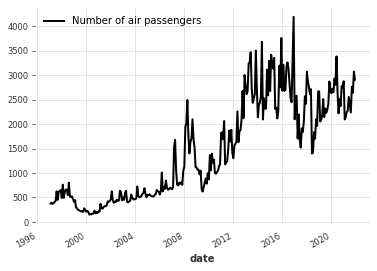

In [7]:
# look for how many years we have all the features in total
df = df[['fishoil_price_peru']]
df = df[df.index > "1997-01-01"]
df = df[df.index < "2022-01-01"]
series_oil = darts.TimeSeries.from_dataframe(df)
series_oil.plot(label='Number of air passengers')

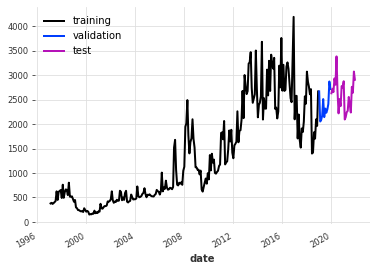

In [8]:
train_oil, val_oil, test_oil = series_oil[:-36], series_oil[-36:-24], series_oil[-24:]
train_oil.plot(label="training")
val_oil.plot(label="validation")
test_oil.plot(label="test")
plt.legend()

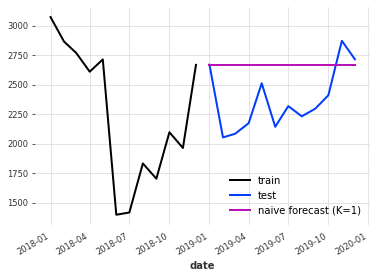

In [9]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train_oil)
naive_forecast = naive_model.predict(12)

train_oil[-12:].plot(label="train")
val_oil.plot(label="test")
naive_forecast.plot(label="naive forecast (K=1)")

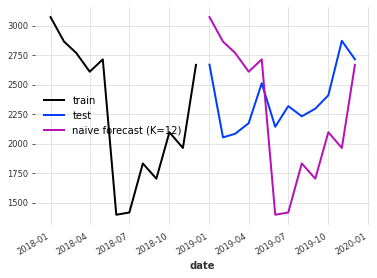

In [10]:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train_oil)
seasonal_forecast = seasonal_model.predict(12)

train_oil[-12:].plot(label="train")
val_oil.plot(label="test")
seasonal_forecast.plot(label="naive forecast (K=12)")

In [11]:
train = train_oil
val = val_oil
test = test_oil
series = series_oil

model Naive drift model obtains MAPE: 22.24%


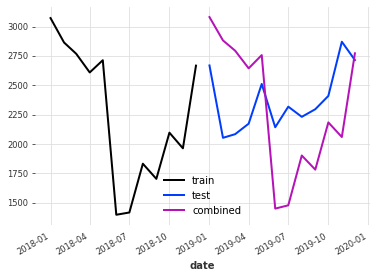

In [12]:
from darts.models import NaiveDrift
from darts.metrics import mape

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(12)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

train_oil[-12:].plot(label="train")
val_oil.plot(label="test")
combined_forecast.plot(label="combined")
#drift_forecast.plot(label="drift")
print("model {} obtains MAPE: {:.2f}%".format(drift_model, mape(val, combined_forecast)))

model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12 obtains MAPE: 12.40%


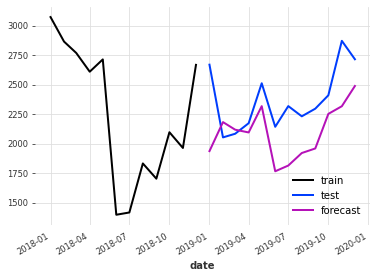

In [13]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta


def eval_model(model):
    model.fit(train)
    forecast = model.predict(12)
    train_oil[-12:].plot(label="train")
    val_oil.plot(label="test")
    forecast.plot(label="forecast")
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))


eval_model(ExponentialSmoothing())

model (T)BATS obtains MAPE: 10.60%


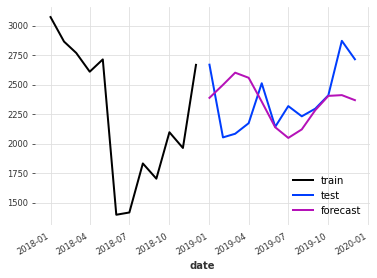

In [14]:
eval_model(TBATS())

In [49]:
from sklearn.model_selection import ParameterGrid
param_grid = {'a': [-3, 2, 1, 0, 1, 2, 3], 'b': [-3, 2, 1, 0, 1, 2, 3]}
params = list(ParameterGrid(param_grid))

In [56]:
params[0]['a']

-3

In [57]:
# Search for the best TBATS model 
from sklearn.model_selection import ParameterGrid
param_grid = {'a': [-3, 2, 1, 0, 1, 2, 3], 'b': [-3, 2, 1, 0, 1, 2, 3]}
params = list(ParameterGrid(param_grid))

best_mape = float("inf")
best_tbats = 0

for param in params:
    model = TBATS(box_cox_bounds = (param['a'], param['b']))
    model.fit(train)
    pred_tbats = model.predict(len(val))
    res = mape(val, pred_tbats)

    if res < best_tbats:
        best_mape = res
        best_tbats = (param['a'], param['b'])

best_tbats_model = TBATS(box_cox_bounds=best_tbats)
best_tbats_model.fit(train)
pred_best_tbats = best_tbats_model.predict(len(val))

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(val, pred_best_tbats), best_tbats
    )
)

train.plot(label="train")
val.plot(label="true")
pred_best_tbats.plot(label="prediction")

KeyboardInterrupt: 

In [16]:
eval_model(AutoARIMA())

KeyboardInterrupt: 

model Theta(2) obtains MAPE: 8.47%


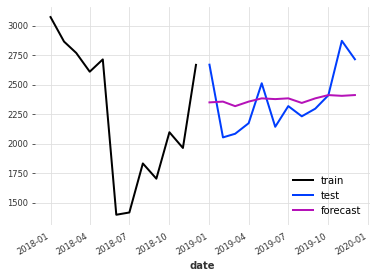

In [ ]:
eval_model(Theta())

model Naive drift model obtains MAPE: 16.64%


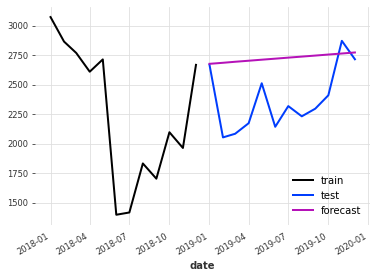

In [ ]:
eval_model(NaiveDrift())

In [ ]:
# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(val, pred_best_theta), best_theta
    )
)

train.plot(label="train")
val.plot(label="true")
pred_best_theta.plot(label="prediction")

In [ ]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(val, pred_best_theta), best_theta
    )
)

In [ ]:
train.plot(label="train")
val.plot(label="true")
pred_best_theta.plot(label="prediction")